### Artificial Intelligence Fundamentals 2023/2024
# Logic Programming Applied to Nethack
### Dealing with Darkness: Corridor Battle and Keyroom Tasks
**Group name:** Fiandora Hack <br> <br>
**Members:**
- Domenico Romano
- Filip Talarek
- Anson Johnson Madambi
- Abdolrahim Tooranian


## 1. Introduction

In Nethack, it is very common to search for something, or to be on your way to a goal, and suddenly you have to fight some enemies. This inspired us to separately solve the problem of keyroom and corridor battle (which is a relaxed form of the original general problem) and eventually combine the two. <br> <br>
More specifically we dealt with a partially observable environment, since the custom map that we created is in dark mode (attribute lit = False). Also, since we have also some enemies (specifically, 4 giant rats against which we had to fight) that can perform random movements and which damage inflicted can be casual, we also dealt with a non-deterministic environment. <br> <br>
About implementation, our goal was to address the general problem of prioritizing actions using a hybrid approach when searching for some objects or pursuing goals, in this case: key, door, etc. The agent needs to decide what to do at each point of time, this is the core of our logic. We tackled the problems of exploration and combat separately and combined them using a centralized Prolog knowledge-base.
In the following cells, we will explore each of the tasks.

## 2. Related Works
For our work, we used Gym, NLE and Minihack. <br>

[Gym](https://www.gymlibrary.dev/index.html) a standard API for reinforcement learning, and a diverse collection of reference environments.

[NLE](https://github.com/facebookresearch/nle) is an environment based on NetHack 3.6.6 and designed to provide a standard RL interface to the game, and comes with tasks that function as a first step to evaluate agents on this new environment. 

[Minihack](https://github.com/facebookresearch/minihack) is a sandbox framework, based on Nethack, for easily designing rich and diverse environments. This one was extremely useful for our project.
Indeed in the preparation phase of our work we addressed the two specific subproblems using the Minihack default environments 
[KeyRoom](https://minihack.readthedocs.io/en/latest/envs/navigation/keyroom.html) and [CorridorBattle](https://minihack.readthedocs.io/en/latest/envs/navigation/battle.html). Then we used Minihack's [LevelGenerator](https://minihack.readthedocs.io/en/latest/getting-started/interface.html#level-generator) in order to generate our custom environment, which includes a first part similar to the CorridorBattle map, and a second part which is quite complex, since there are different rooms and walls which create a complicate path and in which the key, the door and the goal location are placed. Our aim was to create a unique environment in which different subproblems are performed, with the common topic of the darkness.

Looking at the current literature about Nethack, we found that the problems of fighting and exploring have been addressed, but separately, in the following studies: "[Learning Combat in NetHack ](https://ojs.aaai.org/index.php/AIIDE/article/view/12923)" and "[Exploration in NetHack With Secret Discovery](https://ieeexplore.ieee.org/abstract/document/8423691)". In our approach we merged the two challenges in a unique environment.

## 3. Methodologies

### 3.1 The general methodology:
The use of a Prolog KB is transversal to the entire project. We thought to use this general approach because it adapts very well to our tasks and to the function "process_state", which we use to process just a single action of the agent at time. The Prolog KB is both an excellent way to store persistent data and to infer new ones from the already stores. In particular, we use the knowledge base in order to infer the next action that should be done by the agent and to understand in which kind of corridor (vertical or horizontal) the agent is.

### 3.2 The keyroom environment tasks:

These tasks from the minihack env zoo require the agent to pick up a key, navigate to a door, and use the key to unlock the door, reaching the staircase down within the locked room. The action space is the standard movement actions plus the pickup and apply action.

In simple cases, the environment is well lit, and the locations of the key and door are known, but in more complicated cases the environment is partially observable and the agent may not see the key or the door.

To decide generally what action to do we use logic programming, like search for the key, or go the door. This is to ease the integration with combat in the other part of the project. However the details are implemented using other approaches. For example, the general navigation is handled by A star, and this easily solved the simple case of an obseravble environment. However, in the dark mode when the agent doesn’t see its goal, we have to do exploration. First we need to choose which borderline cell we should explore first. A borderline cell is a cell that has some unknown cells adjacent to it. We choose the next cell using a greedy approach, the cell is chosen by two factors:
the euclidean distance and the average distance from other borderline cells for a borderline cell which is explained in the following formula:

$$
\text{selected\_cell} = \underset{\text{cell} \in \text{borderline\_cells}}{\arg\min} \left( euc\_distance((agent\_x, agent\_y), \text{cell}) + \eta \left( \frac{1}{N} \sum_{i=1}^{N} euc\_distance(\text{cell}, \text{borderline\_cells}_i) \right) \right)
$$

We select the cell with the minimum value as defined above, and find a path to that cell using A star. Also, there is some research to be done about tuning hyperparameter eta.

### 3.3 The corridor battle task:
In order to not be killed by rats, it's necessary to face them one by one. It means that the agent should not move outside of the corridor before all the rats will have been killed, otherwise they will surround him and he'll receive multiple attacks at the same time.
To understand if the agent is facing a rat and in which precise location of the corridor (or outside the corridor) he is, considered the partiable visibility issue, we need to check the combination of the adiacent cells (for example if the agent has a corridor tile "#" on his left and another "#" on his right, it means he's in the middle of the corridor).
After having done that, we assert the current location of the agent (and if he's facing a rat) in the KB and accordingly to those and to the number of rats left we can automatically infer which is the next action to do.
### 3.4 The combination of keyroom and corridor battle tasks:
The goal is the same as the keyroom: find the key, open the door, and go through the stairs. The environment is also quite similar but in contrast to the original keyroom, there are mazes and the environment is always dark. Also, it is possible to encounter rats when moving through the corridor.  The strategy of fighting the rats is the same as corridor battle. Agent prioritizes survival so first of all in case of finding rats he will try to fight with them and explore the map later after the risk is gone.
As mentioned, the knowledge-base decides what should the agent do at any point in time, and the agent prioritizes survival so first of all in case of finding rats he will try to fight with them and explore the map later after the risk is gone. The strategy of fighting the rats is the same as corridor battle. Also, exploration and finding the stairs is the same as the keyroom task.

## 4. Practical implementation
Running the next cells, you can watch a demo of how the agent works. For further details about the implentation of the algorithms, check the files "utils_final_fiandora.py" and "kb.py".

In [1]:
from utils_final_fiandora import print_debug, decide_next_cell_to_explore,find_borderline_cells, initialize,perform_action,coordinates_to_actions,astar,obschar_to_mask, actions, positions,  process_state, show_match
from pyswip import Prolog
import matplotlib.pyplot as plt
import numpy as np
import time


In [2]:
NUM_EPISODES = 20
MAX_STEPS = 600
PATH = 'kb.pl'

KB = Prolog()
KB.consult(PATH)

In the following cell, the custom map is created.

In [3]:
import gym
import minihack
import matplotlib.pyplot as plt
from minihack import LevelGenerator
from nle import nethack


map=[
"""
-----       -------------------
|...|       |.................|
|....#######..................|
|...|       |.................|
-----       ----|-...-|-------|
       ---------|-...-|-------|
       |............---|
|------|...|...|....---|
|..........|...|....---|
|..........|...|.......|
|----------|...|--|....|
|---..............|....|
|---|..|..||......|....|
|------------.....|....|
|........---|..........|
|........---|..--------|
|........---|..--------|
|...........|..--------|
|----..........--------|
|-----------|..--------|
------------------------
"""]

lvl_gen = LevelGenerator(map=map[0], lit=False)
lvl_gen.set_start_pos((1, 1))
lvl_gen.add_monster(name="giant rat", place=(29, 3))
lvl_gen.add_monster(name="giant rat", place=(29, 2))
lvl_gen.add_monster(name="giant rat", place=(28, 3))
lvl_gen.add_monster(name="giant rat", place=(28, 2))
lvl_gen.add_door("closed", place=(12,18))
lvl_gen.add_object(name='skeleton key', symbol='(', place=(3,8))
lvl_gen.add_goal_pos((4, 17))





initialize()

MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.OPEN
)

env = gym.make("MiniHack-Skill-Custom-v0",
               observation_keys=('screen_descriptions','chars','glyphs','inv_strs','blstats','message','pixel','pixel_crop'),
               des_file = lvl_gen.get_des(),
               max_episode_steps=MAX_STEPS*2,
               actions = NAVIGATE_ACTIONS)
obs=env.reset() # each reset generates a new environment instance
env.render()





Hello Agent, welcome to NetHack!  You are a lawful human Caveman.               
                        ---                                                     
                        |@.                                                     
                        |..                                                     
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                           

In the following cell, the knowledge base is initialized at the beginning of each step

In [4]:
rewards = []
performed_acts=[]

def run(obs,performed_acts,KB,env,rewards):
    env.reset()
    initialize()

    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []

    # obs = env.reset()
    ep_states.append(obs['pixel'])
    done = False
    info=None


    KB.retractall("standing_next(_)")
    KB.retractall("has(_)")
    KB.retractall("standing_on(_)")
    KB.retractall("in_sight(_)")
    KB.retractall("enter(_)")
    KB.retractall("is_open(_)")

    KB.retractall("position(agent,_,_)")
    KB.retractall("place(_)")
    KB.retractall("corridor_type(_)")

    KB.retractall("num_rats_left(_)")
    KB.asserta("num_rats_left(4)")

    KB.retractall("on_agent_dir(_,_)")
    KB.retractall("inertia_dir(_)")

    KB.retractall("already_in_corridor(_)")
    KB.asserta("already_in_corridor(false_)")

    KB.retractall("last_extreme_rel(_)")
    KB.retractall("last_extreme_abs(_)")
    
    KB.retractall("fight_state(_)")
    KB.asserta("fight_state(off)")

    

    # Main loop
    while not done and steps < MAX_STEPS:

        
        # Get the observation from the env and assert the facts in the kb 
        process_state(obs, KB)
        #print_debug("\n\nNew iteration\n")
        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
       
        action = list(KB.query('action(X)'))[0]["X"]
        #print_debug("ACTION:" + list(KB.query('action(X)'))[0]["X"] + "\n")
      
        # print(f'>> Current action from Prolog: {action}')
        
        only_one_processing = False
        if action:
            navs=[]
            if 'go(stairs)' in action:
                agent_p=positions['agent']
                stairs_p=positions['stairs']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, stairs_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

            elif 'enter(door)' in action:
                agent_p=positions['agent']
                door_p=positions['door']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, door_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                KB.retractall('standing_next(door)')

                
            elif 'opendoor' in action:
                obs, reward, done, info = perform_action("opendoor", env, KB,obs)
                performed_acts+=["opendoor"]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()
                
            elif "pick" in action:
                obs, reward, done, info = perform_action("pick", env, KB,obs)
                performed_acts+=["pick"]
                steps += 1
                process_state(obs, KB)
                ep_states.append(obs['pixel'])
                env.render()
                
            elif "go(door)" in action:
                agent_p=positions['agent']
                door_p=positions['door_front']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, door_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

                
            elif "go(key)" in action:
                agent_p=positions['agent']

                key_p=positions['key']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, key_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
                
            elif 'explore' in action:
                b_cell=decide_next_cell_to_explore(obs)
                agent_p=positions['agent']
                masked=obschar_to_mask(obs)
                # print(agent_p,b_cell)
                path = astar(masked,agent_p, b_cell)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)

            elif 'go(corridor)' in action:
                agent_p=positions['agent']
                corridor_p=positions['corridor_entrance']
                masked=obschar_to_mask(obs)
                path = astar(masked,agent_p, corridor_p)
                path.append(agent_p)
                path.reverse()
                navs = coordinates_to_actions(path)
            else:
               navs=[action]
               only_one_processing = True

                
            for nav in navs:
                performed_acts+=[nav]

                if not only_one_processing:
                    process_state(obs, KB)

                if list(KB.query('action(X)'))[0]["X"] != action:
                    break
                    
                obs, reward, done, info = perform_action(nav, env, KB,obs)
                steps += 1

                if not only_one_processing:
                    process_state(obs, KB)
                ep_states.append(obs['pixel'])
                # env.render()
                
                

        else:
            print("ERROR: impossible to perform any action. Please check assertions and definitions in KB.")
            break


    # Display game with interface
    show_match(ep_states,0,600,360,920)
    # show_match(ep_states,0,200,0,200)
    # Print information about the ended episode
    print(f'Episode {episode} - {steps} steps')
    print(f'End status: {info["end_status"].name}')
    print(f'Final reward: {reward}')
    time.sleep(0.75)

    rewards.append(reward)

    return steps
    


KeyboardInterrupt: 

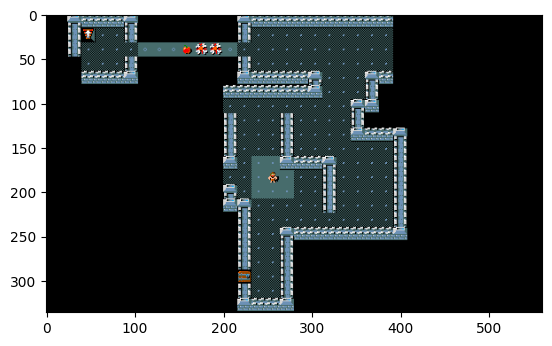

In [5]:
n_steps=[]
for episode in range(NUM_EPISODES):
    steps=run(obs,performed_acts,KB,env,rewards)
    n_steps.append(steps)


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print("The rewards of the episodes are:", rewards)

## 5. Assessment
In the following cells you can see the metrics indicating the performance of the agent on the defined evnironment.
We were also able to solve the general problem of keyroom with any randomnly generated room. There is a notebook in the search folder named keyroom.ipynb on github containing that analysis.



In [6]:
n_steps, rewards


([236,
  353,
  233,
  240,
  235,
  317,
  258,
  238,
  233,
  207,
  283,
  244,
  231,
  317,
  272,
  315,
  236,
  314,
  209,
  244],
 [1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0])

In [7]:
sum(rewards)/len(rewards)

1.0

In [8]:
sum(n_steps)/len(n_steps)

260.75

In [10]:
import statistics
import numpy as np

# Calculate basic statistics using the statistics module
mean = statistics.mean(n_steps)
median = statistics.median(n_steps)
std_dev = statistics.stdev(n_steps)
variance = statistics.variance(n_steps)

# Calculate minimum and maximum using NumPy
minimum = np.min(n_steps)
maximum = np.max(n_steps)

# Print the results
print("Mean:", mean)
print("Median:", median)
print("Standard Deviation:", std_dev)
print("Variance:", variance)
print("Minimum:", minimum)
print("Maximum:", maximum)


Mean: 260.75
Median: 242.0
Standard Deviation: 41.44479524176201
Variance: 1717.671052631579
Minimum: 207
Maximum: 353


## 6. Conclusion
During the design and implementation of our problem, we encountered several difficulties, and many bugs. Perhaps, we made a mistake in the approximating the scope of the project, as we thought the problem would be much more simpler to solve and to implement. In any case, by relaxing some aspects of the general problem we were able to get good results, as shown in by the results in assesment. The agent is able to solve complex mazes, and prioritze its tasks. However, there are many aspects that need to be addressed as future work: some hyperparameters in the exploration, defining other types of monsters, different environment conditions, etc. Also, we designed the agent in a flexible way, and new features and tasks could be added with ease.

## 7. Appendix
### Team contributions
The project was initially divided mostly in two parts, handled by two subgroups. Domenico and Filip worked on the corridor battle task while Anson and Abdolrahim(Rahim) worked on the key-room task. In the second part of the project (the one about merging the two different tasks in the final custom map) all the members of the group worked participated.
### Github metrics
The repository and metrics can be found at this link, https://github.com/isole-01/Nethack_Fiandora
### Relationship with the course
This project was based on theme of Logic Programming applied to Nethack which is used in the course. A* search and greedy approach  algorithm  were  taken from the types of informed search algorithms to apply in Corridor battle and keyroom as we studied.
